In [25]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import eugene as eu
from pyjaspar import jaspardb
import pyranges as pr
from pymemesuite.common import MotifFile, Sequence
from pymemesuite.fimo import FIMO

## Dev

In [42]:
from pyjaspar import jaspardb
def get_jaspar_motifs(
    motif_accs=None,
    motif_names=None,
    collection=None,
    release='JASPAR2020'
):
    assert motif_accs or motif_names or collection, "Must provide either motif_accs, motif_names, or collection"
    jdb_obj = jaspardb(release='JASPAR2020')
    if motif_accs:
        motifs = [jdb_obj.fetch_motif_by_id(acc) for acc in motif_accs]
    elif motif_names:
        motifs = [motif for name in motif_names for motif in jdb_obj.fetch_motifs_by_name(name)]
    elif collection:
        motifs = jdb_obj.fetch_motifs(
            collection = collection,
            tax_group = ['vertebrates']
        )
    return motifs


def save_motifs_as_meme(
    jaspar_motifs,
    filename
):
    meme_file = open(filename, 'w')
    meme_file.write("MEME version 4 \n")
    print(f'Saved PWM File as : {filename}')
    for motif in jaspar_motifs:
        acc = motif.base_id
        name = motif.name
        pwm = np.array(list(motif.pwm.values()))
        filter_size = pwm.shape[1]
        meme_file.write("\n")
        meme_file.write(f"MOTIF {acc} {name}\n")
        meme_file.write(
            "letter-probability matrix: alength= 4 w= %d \n" % np.count_nonzero(np.sum(pwm[:, :], axis=0)))
        for j in range(0, filter_size):
            if np.sum(pwm[:, j]) > 0:
                meme_file.write(
                    str(pwm[0, j]) + "\t" + 
                    str(pwm[1, j]) + "\t" + 
                    str(pwm[2, j]) + "\t" + 
                    str(pwm[3, j]) + "\n"
                )
    meme_file.close()

def load_meme(filename):
    memesuite_motifs = []
    with MotifFile(filename) as motif_file:
        for motif in motif_file:
            memesuite_motifs.append(motif)
        bg = motif_file.background
    return memesuite_motifs, bg


def fimo_motifs(
    sdata,
    pymeme_motifs,
    background
):
    pymeme_seqs = [Sequence(str(seq), name.encode()) for seq, name in zip(sdata.seqs, sdata.names)]
    fimo = FIMO(both_strands=True)
    motif_scores = []
    for motif in pymeme_motifs:
        pattern = fimo.score_motif(motif, pymeme_seqs, background)
        for m in pattern.matched_elements:
            motif_scores.append([
                m.source.accession.decode(),
                m.start,
                m.stop,
                m.strand,
                m.score,
                m.pvalue,
                m.qvalue,
                motif.accession.decode(),
                motif.name.decode()
            ])
    return motif_scores


def score_seqs(
    sdata,
    motif_accs=None,
    motif_names=None,
    collection=None,
    release='JASPAR2020',
    filename="motifs.meme"
):
    assert motif_accs or motif_names or collection, "Must provide either motif_accs, motif_names, or collection"
    motifs = get_jaspar_motifs(
        motif_accs=motif_accs,
        motif_names=motif_names,
        collection=collection,
        release=release
    )
    save_motifs_as_meme(motifs, filename)
    memesuite_motifs, bg = load_meme(filename)
    scores = fimo_motifs(sdata, memesuite_motifs, bg)
    dataframe = pr.PyRanges(pd.DataFrame(scores, columns=['Chromosome', 'Start', 'End', 'Strand', 'Score', 'Pvalue', 'Qvalue', 'Accession', 'Name']))
    return dataframe


def jaspar_annots_sdata(
    sdata,
    motif_accs=None,
    motif_names=None,
    collection=None,
    release='JASPAR2020',
    filename="motifs.meme",
    copy=False
):
    sdata = sdata.copy() if copy else sdata
    sdata.pos_annot = score_seqs(
        sdata,
        motif_accs=motif_accs,
        motif_names=motif_names,
        collection=collection,
        release=release,
        filename=filename
    )
    return sdata if copy else None

## Integration

In [43]:
sdata = eu.datasets.random1000()

In [46]:
eu.external.meme.jaspar_annots_sdata?

Signature:
eu.external.meme.jaspar_annots_sdata(
    sdata,
    motif_accs=None,
    motif_names=None,
    collection=None,
    release='JASPAR2020',
    filename='motifs.meme',
    copy=False,
)
Docstring: <no docstring>
File:      /workspaces/EUGENe/eugene/external/meme/_fimo.py
Type:      function


In [48]:
eu.external.meme.jaspar_annots_sdata(
    sdata,
    motif_accs=['MA0048.1', 'MA0049.1']
)

Saved PWM File as : motifs.meme


No importance scores given, outputting just sequence


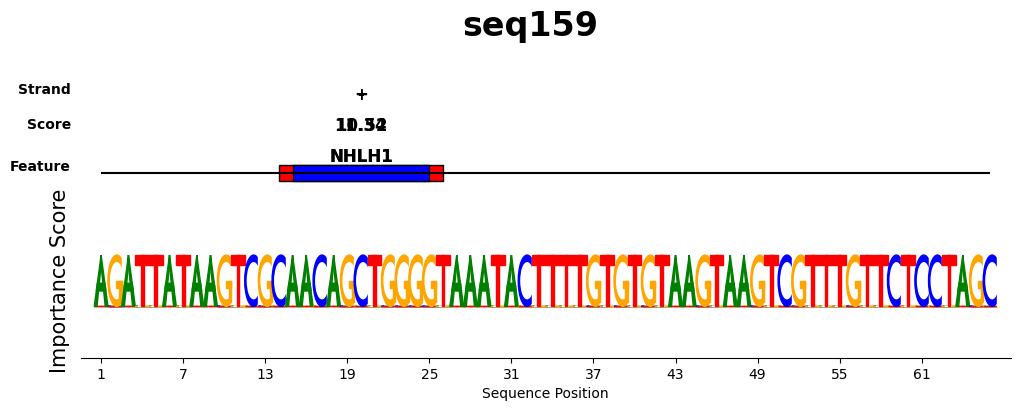

In [51]:
eu.pl.seq_track(
    sdata,
    seq_id="seq159"
)

In [49]:
sdata.pos_annot

,Chromosome,Start,End,Strand,Score,Pvalue,Qvalue,Accession,Name
0,seq143,22,13,-,11.267327,0.000054,1.000000,MA0049,hb
1,seq159,14,25,+,10.520408,0.000063,0.699513,MA0048,NHLH1
2,seq159,25,14,-,11.336735,0.000041,0.699513,MA0048,NHLH1
3,seq173,20,29,+,10.980198,0.000083,1.000000,MA0049,hb
4,seq228,56,45,-,10.938776,0.000051,0.699513,MA0048,NHLH1
5,seq262,28,19,-,11.247525,0.000056,1.000000,MA0049,hb
6,seq418,56,47,-,11.346535,0.000051,1.000000,MA0049,hb
7,seq429,28,39,+,9.775510,0.000087,0.699513,MA0048,NHLH1
8,seq468,46,57,+,11.255102,0.000043,0.699513,MA0048,NHLH1
9,seq468,57,46,-,13.153061,0.000016,0.657199,MA0048,NHLH1


In [35]:
jaspar_annots_sdata(sdata, collection="CORE") 
sdata.pos_annot

Saved PWM File as : motifs.meme


,Chromosome,Start,End,Strand,Score,Pvalue,Qvalue,Accession,Name
0,seq001,11,27,+,6.265306,0.000078,0.370748,MA0113,NR3C1
1,seq001,11,27,+,5.581633,0.000099,0.441127,MA0727,NR3C2
2,seq001,3,14,+,10.756098,0.000077,0.972898,MA1624,Stat5a
3,seq001,6,15,+,12.744898,0.000037,0.318627,MA0764,ETV4
4,seq001,28,18,-,10.234694,0.000099,0.726914,MA1561,SOX12
...,...,...,...,...,...,...,...,...,...
8415,seq999,50,65,+,14.121951,0.000007,0.153215,MA1107,KLF9
8416,seq999,22,32,+,10.532258,0.000097,0.969510,MA0143,SOX2
8417,seq999,31,23,-,11.846939,0.000049,0.716396,MA0078,Sox17
8418,seq999,54,44,-,11.806122,0.000046,0.481668,MA0812,TFAP2B(var.2)


In [37]:
jaspar_annots_sdata(sdata, motif_names=["GATA1"]) 
sdata.pos_annot

Saved PWM File as : motifs.meme


,Chromosome,Start,End,Strand,Score,Pvalue,Qvalue,Accession,Name
0,seq112,29,19,-,12.198582,0.000040,1.0,MA0035,GATA1
1,seq137,32,42,+,11.134752,0.000097,1.0,MA0035,GATA1
2,seq215,55,65,+,11.113475,0.000098,1.0,MA0035,GATA1
3,seq566,53,43,-,11.482270,0.000079,1.0,MA0035,GATA1
4,seq738,36,46,+,12.070922,0.000046,1.0,MA0035,GATA1


No importance scores given, outputting just sequence


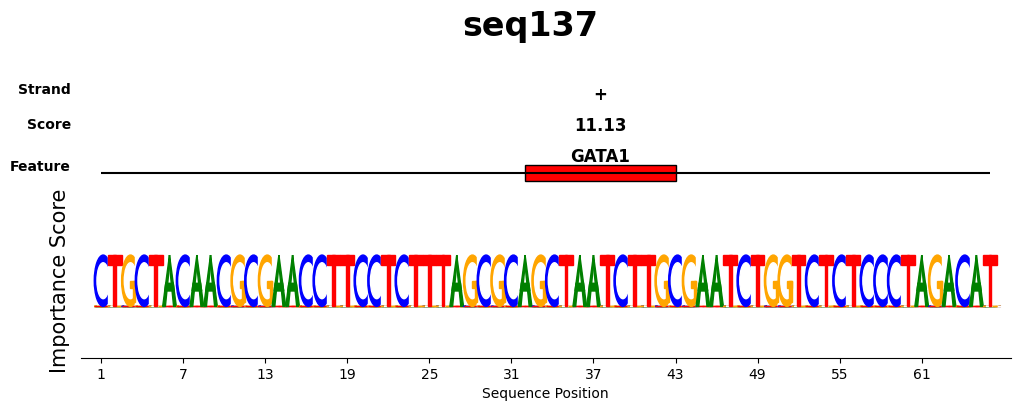

In [39]:
eu.pl.seq_track(
    sdata,
    seq_id="seq137"
)

In [186]:
# Unit testing
single_test = get_jaspar_motifs(motif_accs=['MA0095.2'])
multi_test = get_jaspar_motifs(motif_names=['CTCF', 'GATA1'])
motifs = get_jaspar_motifs(motif_names=['CTCF', "GATA1"])
save_motifs_as_meme(motifs, "test_meme2.out")
annots = fimo_motifs(sdata, *load_meme("test_meme2.out"))
score_df = score_seqs(sdata=sdata, motif_accs=['MA0095.2'], filename="test_meme.out")

Saved PWM File as : test_meme2.out


---

# Scratch

In [4]:
!wget https://raw.githubusercontent.com/althonos/pymemesuite/main/tests/data/fimo/prodoric_mx000001_meme.txt
!wget https://raw.githubusercontent.com/althonos/pymemesuite/main/tests/data/fimo/mibig-genes.fna

--2022-08-22 23:51:05--  https://raw.githubusercontent.com/althonos/pymemesuite/main/tests/data/fimo/prodoric_mx000001_meme.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712 [text/plain]
Saving to: ‘prodoric_mx000001_meme.txt.1’

prodoric_mx000001_m 100%[===================>]     712  --.-KB/s    in 0s      

2022-08-22 23:51:05 (57.5 MB/s) - ‘prodoric_mx000001_meme.txt.1’ saved [712/712]

--2022-08-22 23:51:06--  https://raw.githubusercontent.com/althonos/pymemesuite/main/tests/data/fimo/mibig-genes.fna
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
def filters_to_meme(pwm, output_file_path):
    """
    Function to convert pwm array to meme file
    :param pwm: numpy.array, pwm matrices, shape (U, 4, filter_size), where U - number of units
    :param output_file_path: string, the name of the output meme file
    """

    n_filters = pwm.shape[0]
    filter_size = pwm.shape[2]
    meme_file = open(output_file_path, 'w')
    meme_file.write("MEME version 4 \n")

    print('Saved PWM File as : {}'.format(output_file_path))

    for i in range(0, n_filters):
        if np.sum(pwm[i, :, :]) > 0:
            meme_file.write("\n")
            meme_file.write("MOTIF filter%s \n" % i)
            meme_file.write(
                "letter-probability matrix: alength= 4 w= %d \n" % np.count_nonzero(np.sum(pwm[i, :, :], axis=0)))

        for j in range(0, filter_size):
            if np.sum(pwm[i, :, j]) > 0:
                meme_file.write(str(pwm[i, 0, j]) + "\t" + str(pwm[i, 1, j]) + "\t" + str(pwm[i, 2, j]) + "\t" + str(
                    pwm[i, 3, j]) + "\n")

    meme_file.close()

In [ ]:
def pwm_to_meme(pwm, output_file_path, acc, name):
    """
    Function to convert pwm array to meme file
    :param pwm: numpy.array, pwm matrices, shape (U, 4, filter_size), where U - number of units
    :param output_file_path: string, the name of the output meme file
    """

    n_filters = pwm.shape[0]
    filter_size = pwm.shape[2]
    meme_file = open(output_file_path, 'w')
    meme_file.write("MEME version 4 \n")

    print(f'Saved PWM File as : {output_file_path}')

    for i in range(0, n_filters):
        if np.sum(pwm[i, :, :]) > 0:
            meme_file.write("\n")
            meme_file.write(f"MOTIF {acc} {name}\n")
            meme_file.write(
                "letter-probability matrix: alength= 4 w= %d \n" % np.count_nonzero(np.sum(pwm[i, :, :], axis=0)))

        for j in range(0, filter_size):
            if np.sum(pwm[i, :, j]) > 0:
                meme_file.write(str(pwm[i, 0, j]) + "\t" + str(pwm[i, 1, j]) + "\t" + str(pwm[i, 2, j]) + "\t" + str(
                    pwm[i, 3, j]) + "\n")

    meme_file.close()

In [ ]:
# Use pyjaspar to read in
jdb_obj = jaspardb(release='JASPAR2020')
jaspar_motif = jdb_obj.fetch_motif_by_id('MA0095.2')
jaspar_motif.name, jaspar_motif.base_id

('YY1', 'MA0095')

In [ ]:
# Save to meme file with wasserman lab function
pwm_to_meme(np.expand_dims(np.array(list(motif.pwm.values())), axis=0), "test_meme.out")

Saved PWM File as : test_meme.out


In [ ]:
f = MotifFile('test_meme2.out')

In [ ]:
for i in f:
    print(i)

In [ ]:
motif = f.read()
motif.accession

b'MA0531'

In [ ]:
# Read the meme file to Motif for pymemesuite
with MotifFile("test_meme.out") as motif_file:
    motif = motif_file.read()
motif.accession.decode(), motif.name.decode()

('test', 'test2')

In [ ]:
# Perform FIMO on sequences
sdata = eu.datasets.random1000()
pymeme_seqs = [Sequence(str(seq), name.encode()) for seq, name in zip(sdata.seqs, sdata.names)]
fimo = FIMO(both_strands=False)
pattern = fimo.score_motif(motif, pymeme_seqs, motif_file.background)

In [ ]:
fimo = FIMO(both_strands=False)
pattern = fimo.score_motif(motif, pymeme_seqs, motif_file.background)

for m in pattern.matched_elements:
    print(
        m.source.accession.decode(),
        m.start,
        m.stop,
        m.strand,
        m.score,
        m.pvalue,
        m.qvalue
    )

seq056 18 29 + 14.061224489795919 9.363586039748786e-06 0.2182942144793498
seq758 25 36 + 13.561224489795919 1.3757725722382639e-05 0.2182942144793498
seq822 36 47 + 13.40816326530613 1.5280343427657978e-05 0.2182942144793498
seq275 42 53 + 13.295918367346943 1.616994181328517e-05 0.2182942144793498
seq173 40 51 + 12.255102040816325 3.151484975887798e-05 0.28462756301293
seq066 49 60 + 12.244897959183675 3.162528477921445e-05 0.28462756301293
seq647 7 18 + 11.244897959183675 5.165651465399175e-05 0.39849311304507923
seq017 11 22 + 10.816326530612244 6.244671373201486e-05 0.41598405149732437
seq407 1 12 + 10.5 7.330143175078421e-05 0.41598405149732437
seq532 51 62 + 10.34693877551021 7.866432319426316e-05 0.41598405149732437
seq542 30 41 + 10.204081632653057 8.47374919716772e-05 0.41598405149732437


In [ ]:
motif.accession

b'filter0'

In [ ]:
sdata = eu.datasets.random1000()

In [ ]:
motifs = jdb_obj.fetch_motifs_by_name('CTCF')
motifs

In [ ]:
motifs

In [3]:
with MotifFile("prodoric_mx000001_meme.txt") as motif_file:
    motif = motif_file.read()

print(motif.name.decode())
print(motif.consensus)

for row in motif.frequencies:
    print(" ".join(f'{freq:.2f}' for freq in row))

MexR
GTTGAYCYWRTCAAC
0.01 0.01 0.96 0.01
0.01 0.01 0.01 0.97
0.01 0.01 0.01 0.97
0.01 0.01 0.96 0.01
0.97 0.01 0.01 0.01
0.01 0.49 0.01 0.49
0.01 0.96 0.01 0.01
0.01 0.49 0.01 0.49
0.49 0.01 0.01 0.49
0.49 0.01 0.49 0.01
0.01 0.01 0.01 0.97
0.01 0.96 0.01 0.01
0.97 0.01 0.01 0.01
0.97 0.01 0.01 0.01
0.01 0.96 0.01 0.01


In [5]:
import Bio.SeqIO
from pymemesuite.common import Sequence
from pymemesuite.fimo import FIMO

sequences = [
    Sequence(str(record.seq), name=record.id.encode())
    for record in Bio.SeqIO.parse("mibig-genes.fna", "fasta")
]

fimo = FIMO(both_strands=False)
pattern = fimo.score_motif(motif, sequences, motif_file.background)

for m in pattern.matched_elements:
    print(
        m.source.accession.decode(),
        m.start,
        m.stop,
        m.strand,
        m.score,
        m.pvalue,
        m.qvalue
    )

BGC0002035.1_3425_15590 6700 6714 + 9.328571428571422 1.1024163606971822e-05 0.6174858127445146


In [7]:
motif

In [8]:
from Bio.motifs import write

In [15]:
import numpy as np

Saved PWM File as : test.meme


In [32]:
motif.weblogo("test.svg")

/home/vscode/.local/lib/python3.7/site-packages/Bio/motifs/__init__.py:610: BiopythonDeprecationWarning: Motif.format has been deprecated, and we intend to remove it in a future release of Biopython. Instead of motif.format(format_spec), please use format(motif, format_spec).
  BiopythonDeprecationWarning,


In [33]:
motif.pwm

{'A': (0.15702133593641054,
  0.9726676893041417,
  0.9400362571468415,
  0.3494631153256171,
  1.0,
  0.0,
  0.0015339562125226607,
  0.0018128573420722353,
  0.11323385859712731,
  0.12090363965974062,
  0.12536605773253381,
  0.18574815228001673),
 'C': (0.6391019383628503,
  0.0,
  0.013805605912703946,
  0.15576628085343747,
  0.0,
  0.001673406777297448,
  0.0,
  0.0,
  0.7860828336354763,
  0.2344163993864175,
  0.12201924417793893,
  0.6370101798912285),
 'G': (0.11169990238460466,
  0.025240552224236507,
  0.037372751359643006,
  0.457676753590852,
  0.0,
  0.0,
  0.9984660437874774,
  0.9981871426579277,
  0.005299121461441919,
  0.38558081160228697,
  0.6491423790266351,
  0.054525170826941846),
 'T': (0.09217682331613443,
  0.00209175847162181,
  0.008785385580811602,
  0.037093850230093435,
  0.0,
  0.9983265932227026,
  0.0,
  0.0,
  0.09538418630595454,
  0.25909914935155487,
  0.1034723190628922,
  0.12271649700181286)}

In [28]:
from pymemesuite.common import MotifFile

In [29]:


print(motif.name.decode())
print(motif.consensus)

for row in motif.frequencies:
    print(" ".join(f'{freq:.2f}' for freq in row))


CAARATGGCBGC
0.16 0.64 0.11 0.09
0.97 0.00 0.03 0.00
0.94 0.01 0.04 0.01
0.35 0.16 0.46 0.04
1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.99
0.00 0.00 0.99 0.00
0.00 0.00 0.99 0.00
0.11 0.78 0.01 0.10
0.12 0.23 0.38 0.26
0.13 0.12 0.65 0.10
0.19 0.63 0.06 0.12


In [9]:
write(motif, "")

Signature: write(motifs, format)
Docstring:
Return a string representation of motifs in the given format.

Currently supported formats (case is ignored):
 - clusterbuster: Cluster Buster position frequency matrix format
 - pfm : JASPAR simple single Position Frequency Matrix
 - jaspar : JASPAR multiple PFM format
 - transfac : TRANSFAC like files
File:      ~/.local/lib/python3.7/site-packages/Bio/motifs/__init__.py
Type:      function


In [14]:
import pymemesuite

In [ ]:
common.Alphabet(motif.alphabet)

: 

: 

In [47]:
pymemesuite.common.Motif(motif.alphabet)

TypeError: Argument 'alphabet' has incorrect type (expected pymemesuite.common.Alphabet, got str)

In [25]:
from Bio.motifs.jaspar.db import JASPAR5

In [26]:
JASPAR5?

Init signature: JASPAR5(host=None, name=None, user=None, password=None)
Docstring:     
Class representing a JASPAR5 database.

Class representing a JASPAR5 DB. The methods within are loosely based
on the perl TFBS::DB::JASPAR5 module.

Note: We will only implement reading of JASPAR motifs from the DB.
Unlike the perl module, we will not attempt to implement any methods to
store JASPAR motifs or create a new DB at this time.
Init docstring:
Construct a JASPAR5 instance and connect to specified DB.

Arguments:
 - host - host name of the the JASPAR DB server
 - name - name of the JASPAR database
 - user - user name to connect to the JASPAR DB
 - password - JASPAR DB password
File:           ~/.local/lib/python3.7/site-packages/Bio/motifs/jaspar/db.py
Type:           type
Subclasses:     


In [27]:
JASPAR_DB_HOST = 'vm5.cmmt.ubc.ca'
JASPAR_DB_NAME = 'JASPAR_2010'
JASPAR_DB_USER = 'jaspar_r'
JASPAR_DB_PASS = ''

In [28]:
DFLT_COLLECTION = 'CORE'
jdb = JASPAR5(
    host=JASPAR_DB_HOST,
    name=JASPAR_DB_NAME,
    user=JASPAR_DB_USER,
    password=JASPAR_DB_PASS
)

KeyboardInterrupt: 

In [ ]:
ets1 = jdb.fetch_motif_by_id('MA0098')
print ets1